In [1]:
spark

In [25]:
from collections import namedtuple
import datetime
import json
from typing import Dict, Union, Sequence
import textwrap
import itertools
import functools


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.metrics import average_precision_score

from pyspark.sql import Row, Window, DataFrame, Column
from pyspark.sql import types
import pyspark.sql.functions as sf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import project_utils
import propensity_utils
import leaf_node_analysis

# Get data

From [2021_01_15_1_get_leaf_nodes__fixed_training_period.ipynb](2021_01_15_1_get_leaf_nodes__fixed_training_period.ipynb)

In [2]:
data_and_leaves_df = spark.table("kdevries.data_and_leaves_df__analysis_2021_01_15")

In [21]:
data_and_leaves_df.printSchema()

root
 |-- request_id: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- model_name: string (nullable = true)
 |-- product_code: string (nullable = true)
 |-- control_group: string (nullable = true)
 |-- control_group_ratio: double (nullable = true)
 |-- final_decision: string (nullable = true)
 |-- model_score: double (nullable = true)
 |-- model_3ds_threshold: double (nullable = true)
 |-- yyyy_mm_dd: timestamp (nullable = true)
 |-- filter_date: timestamp (nullable = true)
 |-- binary_label: string (nullable = true)
 |-- email_address_hash_distinct_count_digest_2d: short (nullable = true)
 |-- email_address_hash_distinct_count_detected_country_2d: byte (nullable = true)
 |-- email_address_hash_distinct_count_detected_country_1dly_30d2h_2h: byte (nullable = true)
 |-- email_address_hash_distinct_count_ip_address_hash_2d: byte (nullable = true)
 |-- digest_distinct_count_email_address_hash_2d: byte (nullable = true)
 |-- digest_distinct_count_email_address_hash_1dl

# Now calculating the propensity matrix per test week per leaf node

In [5]:
from project_utils import DATA_START_DATE, ANALYSIS_START_DATE, DATA_END_DATE
test_week_start_dates = project_utils.get_week_start_date_range(start=ANALYSIS_START_DATE, end=DATA_END_DATE)

In [18]:
import importlib
importlib.reload(propensity_utils)

from propensity_utils import label_to_boolean

def get_is_test_col(test_week_start_date):
    get_week_train_test_col_name = propensity_utils.get_week_train_test_col_name(test_week_start_date)
    return propensity_utils.label_to_boolean(sf.col(get_week_train_test_col_name))    

In [24]:
from leaf_node_analysis.spark import get_leaf_node_contingency
is_fraud = propensity_utils.label_to_boolean(sf.col("binary_label"))
tree_columns = [f"t{t}" for t in range(1, 76)]

leaf_node_contingency_dfs = [
    get_leaf_node_contingency(
        df=data_and_leaves_df,
        is_fraud_col=is_fraud,
        is_test_col=get_is_test_col(test_week_start_date),
        tree_columns=tree_columns,
    ).withColumn("test_week_start_date", sf.lit(test_week_start_date))
    for test_week_start_date in test_week_start_dates
]

In [28]:
leaf_node_contingency_df = functools.reduce(DataFrame.unionByName, leaf_node_contingency_dfs).repartition(1).cache()

In [30]:
leaf_node_contingency_df.count()

132258

In [35]:
leaf_node_contingency = leaf_node_contingency_df.sort("test_week_start_date", "tree", "leaf").toPandas()

In [36]:
leaf_node_contingency

,tree,leaf,train_non_fraud,train_fraud,test_non_fraud,test_fraud,test_week_start_date
0,t1,LLLLLLLL,19196,394,502,13,2019-12-02
1,t1,LLLLLLLR,167587,722,3365,22,2019-12-02
2,t1,LLLLLLRL,129,49,7,1,2019-12-02
3,t1,LLLLLLRR,491,32,17,0,2019-12-02
4,t1,LLLLLRL,571559,580,13342,18,2019-12-02
...,...,...,...,...,...,...,...
132253,t9,RRLR,425,23,8,0,2020-09-14
132254,t9,RRRLL,167,9,0,0,2020-09-14
132255,t9,RRRLR,286,7,7,0,2020-09-14
132256,t9,RRRRL,3587,43,67,1,2020-09-14


In [37]:
leaf_node_contingency.to_csv("leaf_node_contingency_over_time", index=False)

Verify that we get consistent numbers

In [40]:
leaf_node_contingency.groupby("tree").sum()

,train_non_fraud,train_fraud,test_non_fraud,test_fraud
tree,,,,
t1,38605622,237953,532043,3473
t10,38605622,237953,532043,3473
t11,38605622,237953,532043,3473
t12,38605622,237953,532043,3473
t13,38605622,237953,532043,3473
...,...,...,...,...
t73,38605622,237953,532043,3473
t74,38605622,237953,532043,3473
t75,38605622,237953,532043,3473


In [43]:
from leaf_node_analysis import add_decision_boundary_change_and_confidence_interval

In [44]:
ln_001 = add_decision_boundary_change_and_confidence_interval(leaf_node_contingency, alpha=0.001) 

invalid value encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


In [45]:
ln_001[ln_001["db_change"]]

,tree,leaf,train_non_fraud,train_fraud,test_non_fraud,test_fraud,test_week_start_date,db_change,db_change_15,train_ci_low,test_ci_low
378,t15,RLLRRL,116,177,14,1,2019-12-02,True,False,0.507991,5.252693e-03
4135,t24,RRR,151,256,11,0,2019-12-09,True,False,0.547814,0.000000e+00
6544,t13,LRR,71,204,11,0,2019-12-16,True,False,0.646989,0.000000e+00
9529,t10,LRLRLR,151,241,12,0,2019-12-23,True,False,0.531867,2.775558e-17
9693,t13,LRR,78,217,13,0,2019-12-23,True,False,0.643852,-2.775558e-17
10208,t20,RRLRL,196,279,26,3,2019-12-23,True,False,0.511900,1.932670e-02
15827,t10,LRLRLR,170,252,17,0,2020-01-06,True,False,0.517113,0.000000e+00
15991,t13,LRR,104,251,60,2,2020-01-06,True,False,0.622377,4.448281e-03
16506,t20,RRLRL,221,302,21,0,2020-01-06,True,False,0.505500,0.000000e+00
16731,t24,RRR,163,340,37,3,2020-01-06,True,False,0.604196,1.395952e-02


In [99]:
date = pd.DatetimeIndex(ln_001["test_week_start_date"])
april_2020 = (date.year==2020) & (date.month==4)
test_leaf_gt_20_rows = ln_001["test_non_fraud"] + ln_001["test_fraud"] >= 20

In [100]:
ln_001[ln_001["db_change_15"]  & test_leaf_gt_20_rows]

,tree,leaf,train_non_fraud,train_fraud,test_non_fraud,test_fraud,test_week_start_date,db_change,db_change_15,train_ci_low,test_ci_low
2101,t47,RLR,2041,160,18,14,2019-12-02,False,True,0.056500,0.203368
2221,t50,LLLLLLRL,2116,177,26,14,2019-12-02,False,True,0.060774,0.159503
8882,t60,RR,1271,498,103,2,2019-12-16,False,True,0.247741,0.002623
9304,t74,LRLR,1793,432,143,4,2019-12-16,False,True,0.168072,0.006092
11499,t46,LLRR,1341,398,91,1,2019-12-23,False,True,0.197456,0.000853
12031,t60,RR,1299,528,84,0,2019-12-23,False,True,0.255426,0.000000
12453,t74,LRLR,1839,456,146,1,2019-12-23,False,True,0.172728,0.000534
15180,t60,RR,1385,560,67,0,2019-12-30,False,True,0.255382,0.000000
15602,t74,LRLR,1908,477,106,2,2019-12-30,False,True,0.174431,0.002550
16056,t14,LRLRR,447,160,91,2,2020-01-06,False,True,0.209262,0.002962


In [95]:
ln_001[ln_001["db_change_15"]  & april_2020]

,tree,leaf,train_non_fraud,train_fraud,test_non_fraud,test_fraud,test_week_start_date,db_change,db_change_15,train_ci_low,test_ci_low
56727,t10,LLLLLRLL,1570,120,1,4,2020-04-06,False,True,0.053064,0.205446
56844,t12,LLLLLLR,1121,58,0,2,2020-04-06,False,True,0.032261,0.155914
57066,t15,RLRLRLRL,4698,61,0,2,2020-04-06,False,True,0.008451,0.155914
57086,t16,LLLLLRLL,973,82,0,2,2020-04-06,False,True,0.054690,0.155914
57234,t18,LLRLRLL,2160,88,0,2,2020-04-06,False,True,0.027747,0.155914
57242,t18,LLRRRR,982,45,0,2,2020-04-06,False,True,0.027134,0.155914
57295,t19,LRLLLRL,1658,95,1,3,2020-04-06,False,True,0.038981,0.154833
57537,t22,RLLLLLRR,2749,183,1,7,2020-04-06,False,True,0.049263,0.328570
57639,t24,RLLLLL,5843,147,0,2,2020-04-06,False,True,0.018771,0.155914
57760,t26,LRR,4663,143,4,5,2020-04-06,False,True,0.022687,0.156766


Int64Index([12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
            ...
             9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
           dtype='int64', name='test_week_start_date', length=132258)

In [46]:
ln_05 = add_decision_boundary_change_and_confidence_interval(leaf_node_contingency, alpha=0.05) 

invalid value encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


In [48]:
ln_05[ln_05["db_change"]]

,tree,leaf,train_non_fraud,train_fraud,test_non_fraud,test_fraud,test_week_start_date,train_ci_upp,test_ci_upp,db_change,db_change_15,train_ci_low,test_ci_low
82,t10,LRLRLR,128,198,6,0,2019-12-02,0.691534,0.643442,True,False,0.553396,0.000000
250,t13,RLRLL,100,244,9,1,2019-12-02,0.782494,0.607997,True,False,0.659216,0.017876
378,t15,RLLRRL,116,177,14,1,2019-12-02,0.692781,0.491409,True,False,0.547099,0.011867
463,t16,RLRL,109,194,5,0,2019-12-02,0.724700,0.684095,True,False,0.584781,0.000000
3065,t8,LLR,68,167,4,0,2019-12-02,0.796981,0.730232,True,False,0.649641,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129234,t11,LLRLLLL,258,108,0,4,2020-09-14,0.378504,1.000000,True,False,0.250680,0.510109
129531,t16,LLRLLR,157,86,0,4,2020-09-14,0.459099,1.000000,True,False,0.296487,0.510109
129566,t16,RLLLLRR,79,147,4,0,2020-09-14,0.745752,0.730232,True,False,0.586232,0.000000
130250,t27,RLRR,103,176,4,0,2020-09-14,0.719340,0.730232,True,False,0.572779,0.000000


In [53]:
num_leaves_05 = ln_05.groupby("test_week_start_date")[["db_change", "db_change_15"]].sum()

In [55]:
num_leaves_001 = ln_001.groupby("test_week_start_date")[["db_change", "db_change_15"]].sum()

In [96]:
 def plot_leaves(ln, confidence_level):
    date = ln.index
    plt.plot(date, ln["db_change"], marker="o", label="$t_p=50\%$")
    plt.plot(date, ln["db_change_15"], marker="o", label="$t_p=15\%$")
    plt.xticks(rotation=90)
    plt.title(f"Number of transitions P(Y|X) between train/test\nConfidence Level: {confidence_level:.1%}")
    plt.xlabel("Test week date")
    plt.ylabel("Number of leaves")
    plt.legend()
    plt.grid()

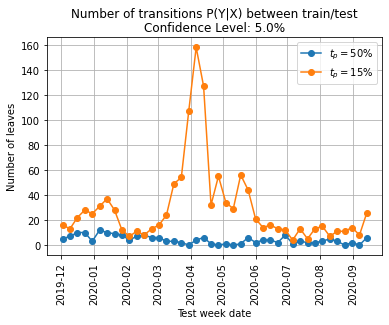

In [97]:
plot_leaves(num_leaves_05, 0.05)

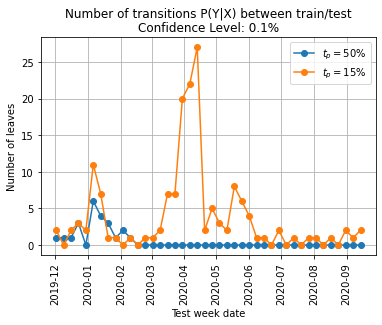

In [98]:
plot_leaves(num_leaves_001, 0.001)